In [399]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms

In [400]:
def load_data_fashion_mnist(resize=None):
    '''下载Fashion-MNIST数据集，然后将其加载到内存中。'''
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(
        root='./data/', train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(
        root='./data/', train=False, transform=trans, download=True)
    
    return mnist_train.data/255, mnist_train.targets, \
            mnist_test.data/255, mnist_test.targets

In [401]:
train_x, train_y, test_x, test_y = load_data_fashion_mnist()
train_x.shape, test_y.shape

(torch.Size([60000, 28, 28]), torch.Size([10000]))

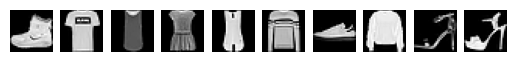

In [402]:
def plot_img(data):
    for i in range(10):
        plt.subplot(1, 10, i+1)
        plt.imshow(data[i], cmap='gray')
        plt.axis('off')
    plt.show()

plot_img(train_x)

In [403]:
def binarization(data, threehold = 0):
    '''将所给的数据集进行二值化'''
    nums = data.shape[0]
    for i in range(nums):
        data[i] = data[i] > threehold
    
    return data

In [404]:
train_x_copy = train_x.clone().detach()
test_x_copy = test_x.clone().detach()

In [405]:
train_x = train_x_copy.clone().detach()
test_x = test_x_copy.clone().detach()
train_x = binarization(train_x, 0.2)
test_x = binarization(test_x, 0.3)

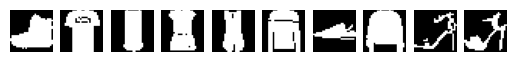

In [406]:
plot_img(train_x)

In [407]:
def cal_prior_conditional(train_x, train_y, eps=1e-40):
    '''通过训练集计算所需要的先验概率和条件概率'''
    # 计算先验概率
    totalNum = len(train_y)
    priorP = torch.bincount(train_y) / totalNum

    # 计算类条件概率
    x = train_x.reshape(totalNum, -1)
    conditionalP = torch.zeros(10, x.shape[1], 2)
    for i in range(10):
        data = x[train_y == i]
        num = data.shape[0]
        # 计算各个元素分别为0和1的条件概率
        conditionalP[i, :, 0] = (num - torch.sum(data, dim=0)) / num + eps
        conditionalP[i, :, 1] = torch.sum(data, dim=0) / num + eps
    
    return priorP, conditionalP

In [408]:
priorP, conditionalP = cal_prior_conditional(train_x, train_y)
priorP.shape, conditionalP.shape

(torch.Size([10]), torch.Size([10, 784, 2]))

In [409]:
def cal_probability(test_x, priorP, conditionalP):
    '''计算测试集的后验概率'''
    x = test_x.reshape(test_x.shape[0], -1)
    prob = torch.zeros(10, x.shape[0])
    zero = x == 0
    one = x == 1
    for i in range(10):
        classConditionalP = conditionalP[i, :, :]
        zeroP = torch.einsum('ij,j->ij', [zero, classConditionalP[:, 0]])
        oneP = torch.einsum('ij,j->ij', [one, classConditionalP[:, 1]])
        iProb = zeroP + oneP
        prob[i, :] = torch.sum(torch.log(iProb), dim=1) * priorP[i]
    
    return prob

In [410]:
prob = cal_probability(test_x, priorP, conditionalP)
prob.shape

torch.Size([10, 10000])

In [411]:
# 计算测试集准确率
def cal_acc(prob, test_y):
    y_hat = torch.argmax(prob, dim=0)
    acc = torch.sum(y_hat == test_y) / test_x.shape[0]
    
    return acc

In [412]:
acc = cal_acc(prob, test_y)
print(f'[测试集准确度]: {acc*100:.2f}%')

[测试集准确度]: 70.34%


In [417]:
def sel_threehold(train_x, train_y, test_x, test_y, threehold):
    '''选择threehold值'''
    accList = []
    for s, i in enumerate(threehold):
        trainX = train_x.clone()
        testX = test_x.clone()
        # 二值化
        trainX = binarization(trainX, i)
        testX = binarization(testX, i)
        # 查看不同二值化后的效果
        plt.subplot(1, len(threehold), s+1)
        plt.imshow(trainX[0], cmap='gray')
        plt.axis('off')
        # 计算先验概率和条件概率
        priorP, conditionalP = cal_prior_conditional(trainX, train_y)
        # 计算后验概率
        prob = cal_probability(testX, priorP, conditionalP)
        # 计算测试集准确度
        acc = cal_acc(prob, test_y) * 100
        accList.append(acc)

    plt.show()

    plt.plot(threehold, accList)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.title('Acc with Threehold')
    plt.xlabel('Threehold')
    plt.ylabel('Acc(%)')
    plt.show()
    print(f'Max acc={max(accList):.2f}% with threehold={threehold[accList.index(max(accList))]}.')

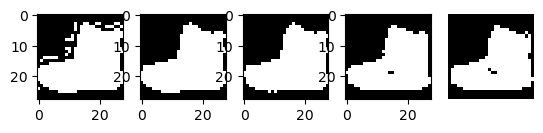

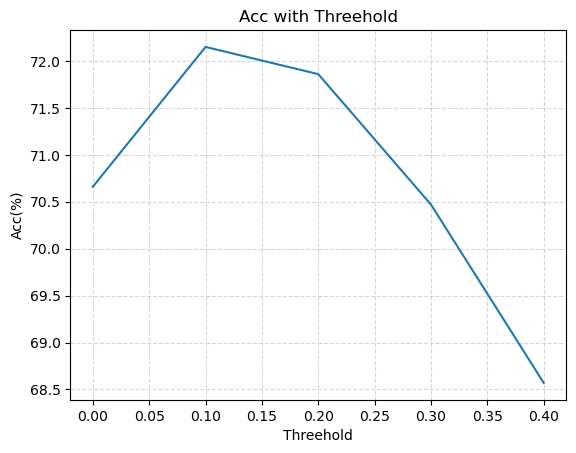

Max acc=72.15% with threehold=0.1.


In [418]:
threehold = [0, 0.1, 0.2, 0.3, 0.4]
sel_threehold(train_x_copy, train_y, test_x_copy, test_y, threehold)